In [1]:
# We will need some packages, this will install them if they are not available
import sys
!{sys.executable} -m pip install numpy python-igraph matplotlib scipy

You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
# temporarily use autoload to modify scripts
%load_ext autoreload
%autoreload 2

In [26]:
from plotting import fit_errors, plot_and_compare_cdf
from data import base, val1, val2
from models import Ms, Ss, prediction
from helpers import gen_testcase
from scipy.stats import poisson, planck, geom, norm, lognorm, binom, truncnorm, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
nodes = 2000
edges = 6
testcase = gen_testcase(nodes, edges)

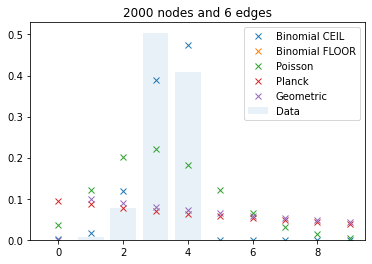

In [23]:
# discrete distributions

# baseic range
x = testcase["x"]
# extended range
x2 = testcase["x2"]

# manual maximum likelihood fitting
# as those are not supported directly by scipy
poifit = poisson(sum([a*b for a, b in zip(testcase["freq"], x)]))
plafit = planck(1/sum(x))
geofit = geom(1/sum(x))
# binomial fit
var = np.var(testcase["expandeddata"])
m = np.mean(testcase["expandeddata"])
p = 1 - var/m
n = m/p
binfit = binom(math.ceil(n), m/math.ceil(n))
binfit2 = binom(math.floor(n), m/math.floor(n))

plt.plot(x2, binfit.pmf(x2), 'x', label="Binomial CEIL")
plt.plot(x2, binfit2.pmf(x2), 'x', label="Binomial FLOOR")

plt.bar(x, testcase["freq"], label="Data", alpha=0.1)

fits = [poifit, plafit, geofit]
names = ["Poisson", "Planck", "Geometric"]

for fit, name in zip(fits, names):
    plt.plot(x2, fit.pmf(x2), 'x', label=name)
plt.legend()
plt.title(str(nodes)+" nodes and "+ str(edges)+" edges")
plt.show()

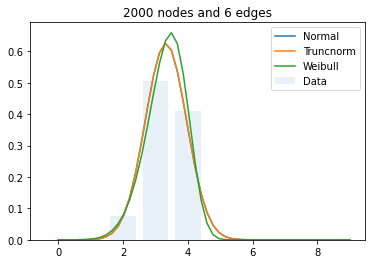

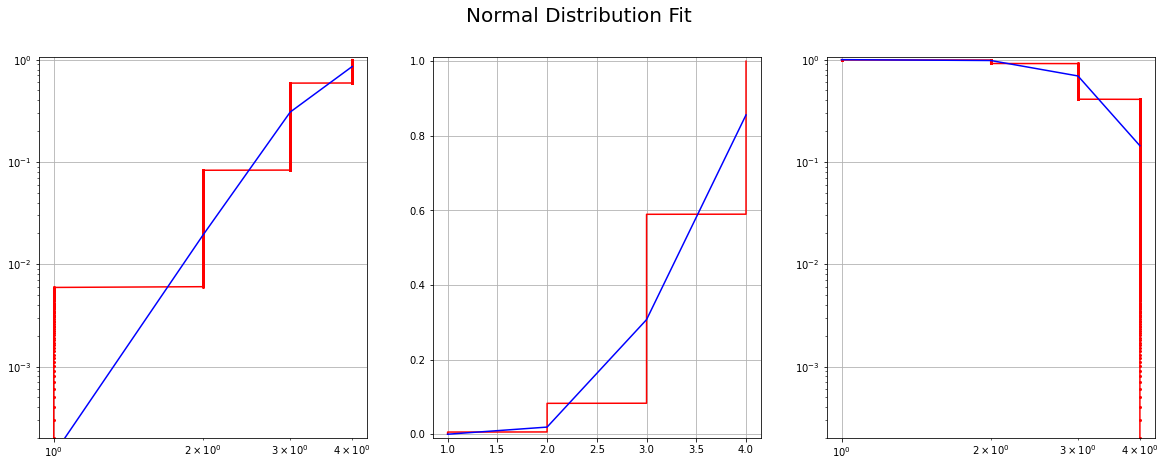

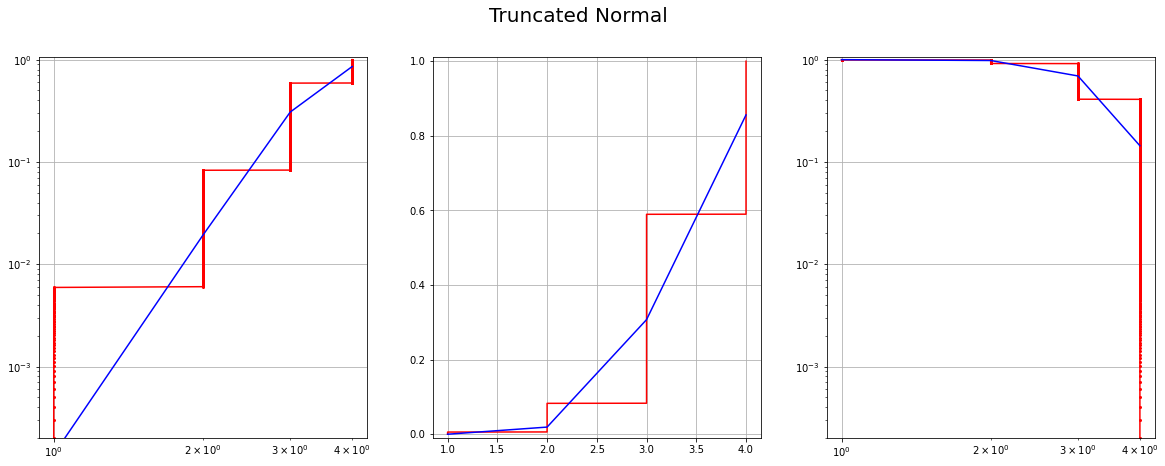

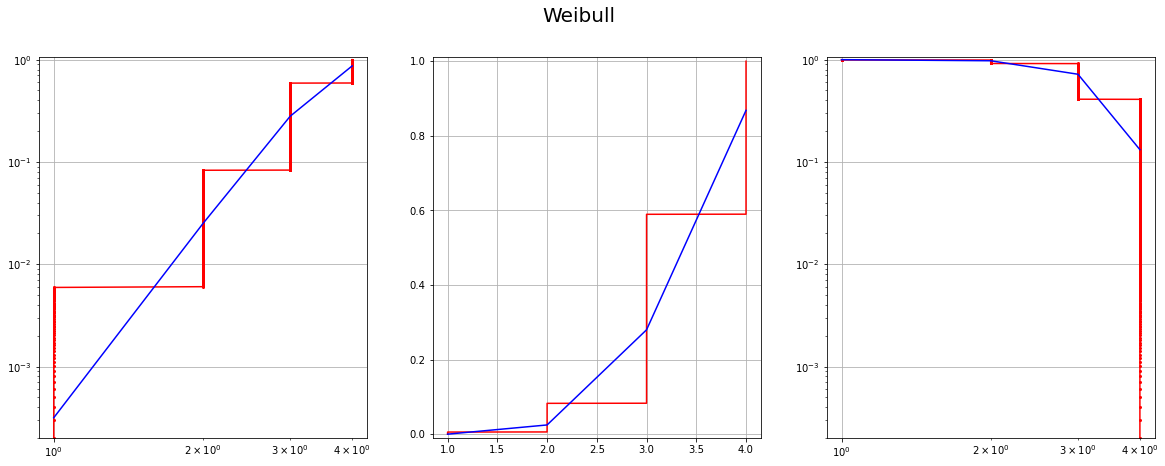

In [25]:
# continuous distributions

plt.bar(testcase["x"], testcase["freq"], label="Data", alpha=0.1)
x = testcase["x3"]

# fit normal distribution
m, s = norm.fit(testcase["expandeddata"])

# Note that the normal distributino is likely overlapped by the truncated normal distribution
plt.plot(x, norm.pdf(x, m, s), label="Normal")

# fit truncated nromal
i1, i2, i3, i4 = truncnorm.fit(testcase["expandeddata"])
plt.plot(x, truncnorm.pdf(x, (-m)/s, (1000-m)/s, loc=m, scale=s), label="Truncnorm")

# fit weibull
d, e, f = weibull_min.fit(testcase["expandeddata"], floc=0)
plt.plot(x, weibull_min.pdf(x, d, e, f), label="Weibull")

# plot everything together
plt.legend()
plt.title(str(nodes)+" nodes and "+ str(edges)+" edges")
plt.show()

# Detailed comparissons for Normal, Truncated normal and Weibull distribution
plot_and_compare_cdf(testcase["expandeddata"], norm(m, s), "Normal Distribution Fit")
plt.show()
plot_and_compare_cdf(testcase["expandeddata"], truncnorm((-m)/s, (1000-m)/s, loc=m, scale=s), "Truncated Normal")
plt.show()
plot_and_compare_cdf(testcase["expandeddata"], weibull_min(d, e, f), "Weibull")
plt.show()

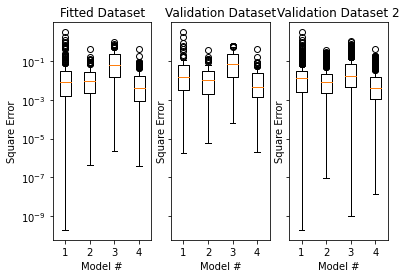

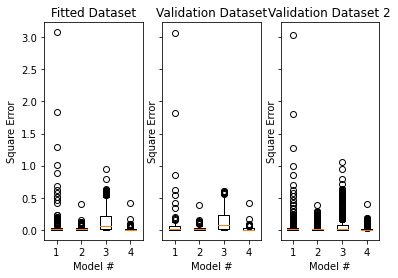

In [37]:
# Logscale version to emphasis lower end of the error
fig = fit_errors(["Fitted Dataset", "Validation Dataset", "Validation Dataset 2"], [base, val1, val2], Ms, "Model #", "Square Error")
# Linear version to emphasis upper end of the error
fig = fit_errors(["Fitted Dataset", "Validation Dataset", "Validation Dataset 2"], [base, val1, val2], Ms, "Model #", "Square Error", False)

In [31]:
from helpers import discretize_pointwise, discretize_intervals
from plotting import discretization

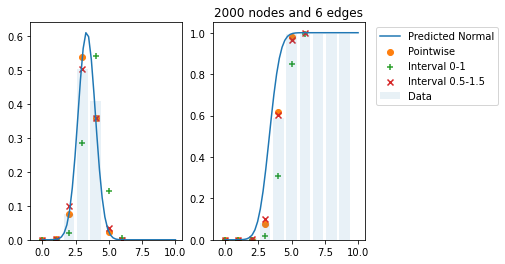

In [36]:
# combined
# prediction based on 
#  * model 4 for mu
#  * model 1 for si
mu, si = prediction(nodes, edges)
# discretization plot of the data, prediction and discretization of the prediction
#  * Re-normalised Pointwise discretization
#  * Intervals around the points: (-inf, 0) for point 0, (0, 1) for 1, etc.
#  * Intervals around the points: (-inf, 0.5) for point 0, (0.5, 1.5) for 1, etc.
discretization(testcase["freq"], mu, si, nodes, edges)

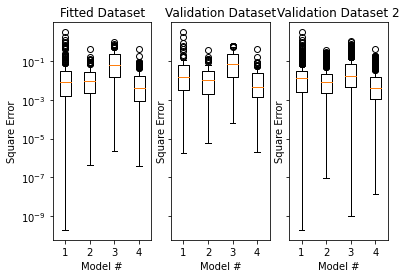

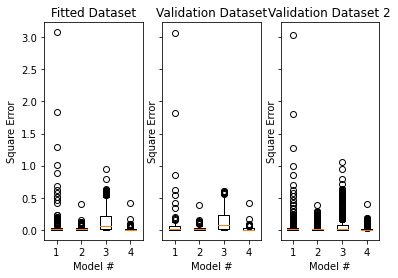